In [1]:
import numpy as np
from os import listdir, path
from PIL import Image
import time
import pickle
import tensorflow as tf
import numpy.random as rng
from sklearn.utils import shuffle
import os

In [2]:
def get_gray():
    assert(len(listdir('tiny-imagenet-200/train')) == 200)
    for label, folder in enumerate(listdir('tiny-imagenet-200/train')):
        assert(len(listdir('tiny-imagenet-200/train/' + folder + '/images')) == 500)
        for image in listdir('tiny-imagenet-200/train/' + folder + '/images'):
            im = Image.open('tiny-imagenet-200/train/' + folder + '/images/' + image)
            im = np.array(im.getdata(), dtype=np.uint8)
            if im.shape != (4096, 3): return im
                
# check image is okay
temp = get_gray()
temp2 = np.array([temp, temp, temp]).T
print(temp2.shape)
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(temp2.astype(np.uint8).reshape(64, 64, 3))
plt.show()

(4096, 3)


<Figure size 640x480 with 1 Axes>

In [3]:
# check all the folders and categories are here/build dataset
t0 = time.time()

if not path.exists('train_data.pkl'):
    x_train, y_train = [], []
    assert(len(listdir('tiny-imagenet-200/train')) == 200)
    for label, folder in enumerate(listdir('tiny-imagenet-200/train')):
        assert(len(listdir('tiny-imagenet-200/train/' + folder + '/images')) == 500)
        for image in listdir('tiny-imagenet-200/train/' + folder + '/images'):
            im = Image.open('tiny-imagenet-200/train/' + folder + '/images/' + image)
            im = np.array(im.getdata(), dtype=np.uint8)
            if im.shape == (4096, 3):
                x_train.append(im.reshape(64, 64, 3))
                y_train.append(label)
            else: # handling grayscale images
                x_train.append(np.array([temp, temp, temp]).T.reshape(64, 64, 3))
                y_train.append(label)

    x_train, y_train = np.array(x_train, dtype=np.uint8), np.array(y_train, dtype=np.uint16)
    print(x_train.shape, y_train.shape)

    print(len(listdir('tiny-imagenet-200/test/images')))
    for fil in listdir('tiny-imagenet-200/test/images'):
        assert(Image.open('tiny-imagenet-200/test/images/' + fil).size == (64, 64))

    pickle.dump((x_train, y_train), open('train_data.pkl', 'wb'))
    
else:
    x_train, y_train = pickle.load(open('train_data.pkl', 'rb'))
    
print('data shapes:', x_train.shape, y_train.shape)
print('time elapsed:', time.time()-t0)

data shapes: (100000, 64, 64, 3) (100000,)
time elapsed: 1.6441001892089844


In [4]:
# try to use gpu
tf.test.is_gpu_available()

True

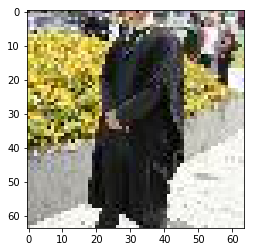

In [5]:
# check image is okay
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(x_train[0].astype(np.uint8))
plt.show()

In [7]:
# # this one sucks

# from keras.models import Sequential
# from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
# #create model
# model = Sequential()
# #add model layers
# model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(64,64,3)))
# model.add(Conv2D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling2D())
# model.add(Flatten())
# model.add(Dense(500, activation='relu'))
# model.add(Dense(200, activation='softmax'))
# print(model.summary())

# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# history = model.fit(x_train, y_train, batch_size=64, epochs=10, shuffle=True, validation_split=0.2)

In [8]:
# from keras.applications import VGG16
# from keras import models
# from keras import layers
# from keras import utils

# conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

# model = models.Sequential()
# model.add(conv_base)
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation="relu"))
# model.add(layers.Dense(200, activation="softmax"))
# print(model.summary())

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# model.fit(x_train, utils.to_categorical(y_train, num_classes=200), batch_size=64, epochs=10, validation_split=0.2, shuffle=True)

In [6]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras import backend as K
from keras.optimizers import Adam
from keras.regularizers import l2

left_input = Input((64, 64, 3))
right_input = Input((64, 64, 3))

# conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
# model = Sequential()
# model.add(conv_base)
# model.add(Flatten())
# model.add(Dense(256, activation="relu"))
# model.add(Dense(200, activation="softmax"))

model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid',
               kernel_regularizer=l2(1e-3)))

encoded_l = model(left_input)
encoded_r = model(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

model = siamese_net

optimizer = Adam(lr = 0.0001)
model.compile(loss="binary_crossentropy",optimizer=optimizer)
print(model.summary())

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         12884800    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1024)         0           sequential_1[1][0]         

In [10]:
Xtrain = x_train[:10000]
train_classes = np.array(range(20))
n_examples = 500 # examples per class
n_classes = 20
Xval = x_train[:10000]
val_classes = np.array(range(20))

In [11]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    _, w, h, _ = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w, 3)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category * n_examples + idx_1]
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2 * n_examples + idx_2]
    
    return pairs, targets

In [12]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)
        

def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    _, w, h, _ = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category * n_examples + ex1]]*N)
    support_set = X[categories * n_examples + indices]
    support_set[0] = X[true_category * n_classes + ex2]
    support_set = support_set
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    print(test_image.shape, support_set.shape)
    pairs = [test_image,support_set]

    return pairs, targets

In [13]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [52]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 16
n_iter = 10000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

model_path = './weights/'

val_accs, losses = [], []
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    losses.append(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        val_accs.append(val_acc)
#         model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 200 iterations: 0.1817949692408244 mins
Train Loss: 0.7083726525306702
Evaluating model on 250 random 20 way one-shot learning tasks ... 

(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(20, 64, 64, 3) (20, 64, 64, 3)
(

KeyboardInterrupt: 

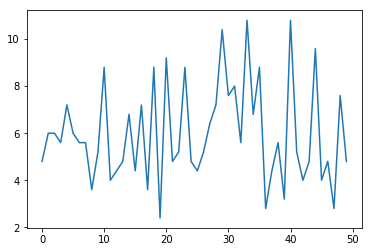

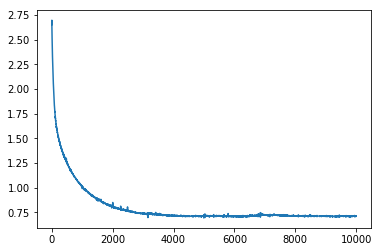

In [41]:
plt.plot(val_accs)
plt.show()

plt.plot(losses)
plt.show()

In [19]:
xtrain = x_train.reshape(200, 500, 64, 64, 3)
Xtrain = xtrain[:,:400]
Xval = xtrain[:,400:]
print(Xtrain.shape, Xval.shape)
train_classes = np.array(range(200))
val_classes = np.array(range(200))

def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h, _ = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,))# ,replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,3)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 3)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h, 3)
    
    return pairs, targets


def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)
        
        
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h, _ = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,3)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,3)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets


def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct


# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 128
n_iter = 10000 # No. of training iterations
N_way = 10 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

losses, val_accs, train_accs = [], [], []
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    losses.append(loss)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        val_accs.append(val_acc)
        train_acc = test_oneshot(model, N_way, n_val, s='train', verbose=True)
        train_accs.append(train_acc)
#         model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

(200, 400, 64, 64, 3) (200, 100, 64, 64, 3)
Starting training process!
-------------------------------------

 ------------- 

Time for 200 iterations: 0.6980172832806905 mins
Train Loss: 0.563449501991272
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 44.8% 10 way one-shot learning accuracy 

Current best: 44.8, previous best: -1

 ------------- 

Time for 400 iterations: 1.5461405952771505 mins
Train Loss: 0.5052560567855835
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 33.6% 10 way one-shot learning accuracy 


 ------------- 

Time for 600 iterations: 2.3929349621136984 mins
Train Loss: 0.5365878343582153
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 36.0% 10 way one-shot learning accuracy 


 ------------- 

Time for 800 iterations: 3.2386770129203795 mins
Train Loss: 0.5192475318908691
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an ave

Got an average of 40.0% 10 way one-shot learning accuracy 


 ------------- 

Time for 7400 iterations: 31.128181982040406 mins
Train Loss: 0.5164325833320618
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 36.8% 10 way one-shot learning accuracy 


 ------------- 

Time for 7600 iterations: 31.97649851242701 mins
Train Loss: 0.5165761709213257
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 39.6% 10 way one-shot learning accuracy 


 ------------- 

Time for 7800 iterations: 32.82388030687968 mins
Train Loss: 0.4299902319908142
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 38.0% 10 way one-shot learning accuracy 


 ------------- 

Time for 8000 iterations: 33.67044492959976 mins
Train Loss: 0.5119986534118652
Evaluating model on 250 random 10 way one-shot learning tasks ... 

Got an average of 39.6% 10 way one-shot learning accuracy 


 ------------- 

Time for 8200 ite

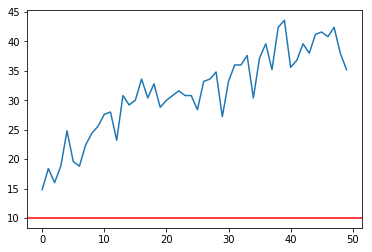

In [11]:
plt.plot(val_accs)
plt.axhline(y=10, color='r')
plt.show()

In [14]:
e = 0.2
c = 200
p = 1/2
same = (1-e)**2 + (e/(c-2))**2 * (c-2)
diff = 1 - (((1-e)*e/(c-2) + (e/(c-2))**2 * (c-2)))
print(p * same + (1-p) * diff)
# plt.scatter(np.linspace(0.9,1,100), y)

0.8195959595959597


In [33]:
test_batch_size = 400
x = get_batch(test_batch_size, s='val')
preds = model.predict(x[0])
# print(preds)
preds[preds>0.5] = 1
preds[preds<0.5] = 0
preds = preds.flatten()
labels = x[1]

print(sum([1 if preds[i] == labels[i] else 0 for i in range(len(labels))])/test_batch_size)


0.7125


In [7]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras import backend as K
from keras.optimizers import Adam
from keras.regularizers import l2

left_input = Input((64, 64, 3))
right_input = Input((64, 64, 3))

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
for layer in conv_base.layers[:-1]: layer.trainable = False
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
print(model.summary())
    

encoded_l = model(left_input)
encoded_r = model(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

model = siamese_net

optimizer = Adam(lr = 0.0001)
model.compile(loss="binary_crossentropy",optimizer=optimizer)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
Total params: 15,239,232
Trainable params: 524,544
Non-trainable params: 14,714,688
_________________________________________________________________
None
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
_______________________________________________

(200, 400, 64, 64, 3) (200, 100, 64, 64, 3)
